In [1]:
import pandas as pd
import numpy as np

In [2]:
#A cleaned version Brazil MST data (only for 2005)
data = pd.read_stata('C:/Users/user/Desktop/Advanced Data Analysis with Python/Datasets/Brazil MST data 2005.dta')
data.columns

Index(['ibgecode', 'state', 'latitude', 'longitude', 'invasions_count',
       'reforms_count', 'invasions_count_cum', 'invasions_dum', 'log_income',
       'ln_agriculturalproductivity', 'codigo', 'PT_voteshare',
       'infantmortality', 'BF_coverage1000', 'log_invasions_count_cum',
       'log_intended_lands1995'],
      dtype='object')

### Installation of Geopandas

In [12]:
#pip install geopandas

If you get trouble while installing geopandas, follow the conda way. Please follow the conda section in the following link: https://geopandas.org/en/stable/getting_started/install.html

Summary, run following codes in anaconda prompt, give your permission if asked:

1. conda install --channel conda-forge geopandas

2. conda create -n geo_env

3. conda activate geo_env

4. conda config --env --add channels conda-forge

5. conda config --env --set channel_priority strict

6. conda install python=3 geopandas


Then, activate geo_env in the anaconda prompt, and call "jupyter notebook" in that environment. Then you are using your notebook in a separate place. Note that, python might ask you to install some packages again, you are in a new zone.

In [31]:
import geopandas

### Read, merge, and plot

In [32]:
import geopandas as gpd

shapefile = gpd.read_file("BR/BRMUE250GC_SIR.shp")
print(shapefile)

       ibgecode                                           geometry
0     1501956.0  POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...
1     2111250.0  POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...
2     5201454.0  POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...
3     5202353.0  POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...
4     1502855.0  POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...
...         ...                                                ...
5567  3535507.0  POLYGON ((-50.69420 -22.39885, -50.69410 -22.3...
5568  5200209.0  POLYGON ((-48.86197 -17.98972, -48.86111 -17.9...
5569  4316808.0  POLYGON ((-52.46848 -29.70647, -52.46847 -29.7...
5570  4217303.0  POLYGON ((-53.10221 -26.93414, -53.10236 -26.9...
5571  2611705.0  POLYGON ((-35.94368 -8.06130, -35.93697 -8.047...

[5572 rows x 2 columns]


<AxesSubplot:>

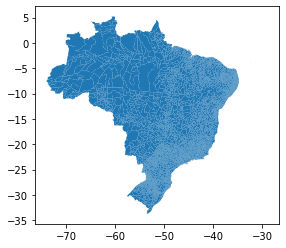

In [5]:
shapefile.plot()
#we don't have any varaible yet, only ibgecode and geometry

In [33]:
#Let's merge them
merged_data = shapefile.merge(data, on='ibgecode')

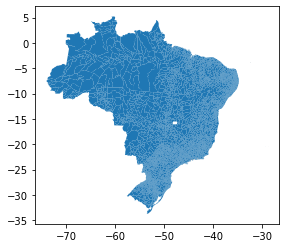

In [19]:
merged_data.plot()

In [75]:
merged_data.boundary

2       LINESTRING (-51.14230 -18.29672, -51.14236 -18...
3       LINESTRING (-51.69953 -16.23270, -51.69957 -16...
6       LINESTRING (-41.67992 -11.92165, -41.66947 -11...
7       LINESTRING (-49.82514 -21.58632, -49.82509 -21...
8       LINESTRING (-52.32292 -29.74821, -52.33270 -29...
                              ...                        
5563    LINESTRING (-40.21792 -10.55208, -40.21585 -10...
5564    LINESTRING (-50.69420 -22.39885, -50.69410 -22...
5566    LINESTRING (-52.46848 -29.70647, -52.46847 -29...
5567    LINESTRING (-53.10221 -26.93414, -53.10236 -26...
5568    LINESTRING (-35.94368 -8.06130, -35.93697 -8.0...
Length: 4885, dtype: geometry

In [76]:
merged_data.centroid

C:\Users\user\AppData\Local\Temp/ipykernel_10884/2756585028.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_data.centroid


2       POINT (-51.26305 -18.21684)
3       POINT (-51.58454 -16.35347)
6       POINT (-41.52394 -11.97777)
7       POINT (-49.76275 -21.56950)
8       POINT (-52.24514 -29.75926)
                   ...             
5563    POINT (-40.36237 -10.60151)
5564    POINT (-50.62658 -22.45910)
5566    POINT (-52.40724 -29.64664)
5567    POINT (-53.04001 -26.89721)
5568     POINT (-35.88290 -8.08195)
Length: 4885, dtype: geometry

In [20]:
print(merged_data.head())

    ibgecode                                           geometry state  \
0  1501956.0  POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...    PA   
1  2111250.0  POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...    MA   
2  5201454.0  POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...    GO   
3  5202353.0  POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...    GO   
4  1502855.0  POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...    PA   

   latitude  longitude  invasions_count  reforms_count  invasions_count_cum  \
0    -1.671    -46.529              0.0            0.0                  0.0   
1    -5.051    -44.584              0.0            0.0                  0.0   
2   -18.299    -51.145              0.0            0.0                  0.0   
3   -16.386    -51.560              0.0            0.0                  0.0   
4    -1.888    -55.117              0.0            2.0                  0.0   

   invasions_dum  log_income  ln_agriculturalproductivity  codigo  \
0            0.0 

In [22]:
# Check what kind of object merged_data is
print(type(merged_data))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [23]:
# Check the type of the geometry attribute
print(type(merged_data.geometry))

<class 'geopandas.geoseries.GeoSeries'>


In [24]:
# Inspect the first rows of the geometry
print(merged_data.geometry.head())

0    POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...
1    POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...
2    POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...
3    POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...
4    POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...
Name: geometry, dtype: geometry


In [25]:
# Inspect the area of the municipalities
print(merged_data.geometry.area)

0       0.196686
1       0.028806
2       0.051432
3       0.090886
4       0.116322
          ...   
5564    0.087868
5565    0.038651
5566    0.068333
5567    0.018694
5568    0.025759
Length: 5569, dtype: float64


C:\Users\user\AppData\Local\Temp/ipykernel_3152/711761555.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(merged_data.geometry.area)


<AxesSubplot:>

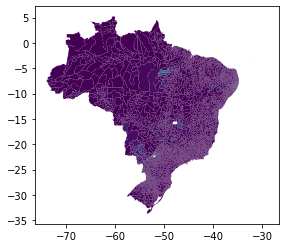

In [8]:
#Plot by invasion count
merged_data.plot(column='invasions_count_cum')

<AxesSubplot:>

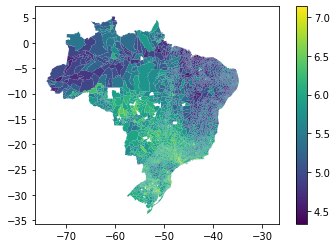

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
merged_data.plot(column='log_income', ax=ax, legend=True)

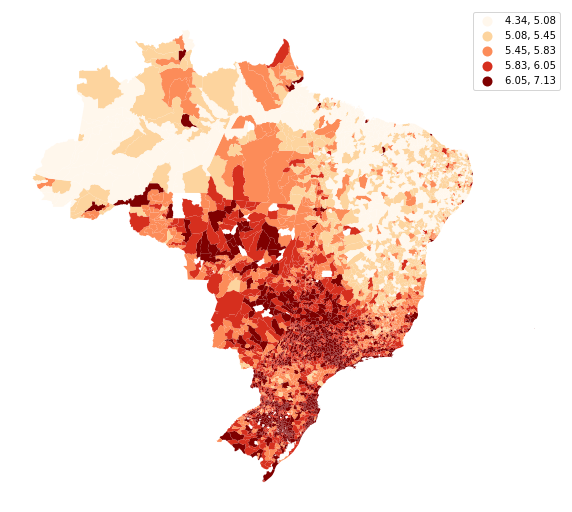

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='log_income', cmap='OrRd', scheme='quantiles', ax=ax, legend=True)
ax.set_axis_off()
plt.show()

<AxesSubplot:>

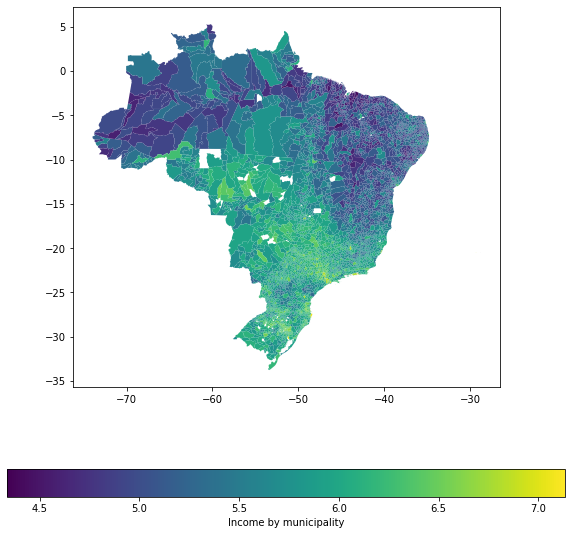

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='log_income', ax=ax, legend=True, 
                 legend_kwds={'label': "Income by municipality", 'orientation': "horizontal"})

<AxesSubplot:>

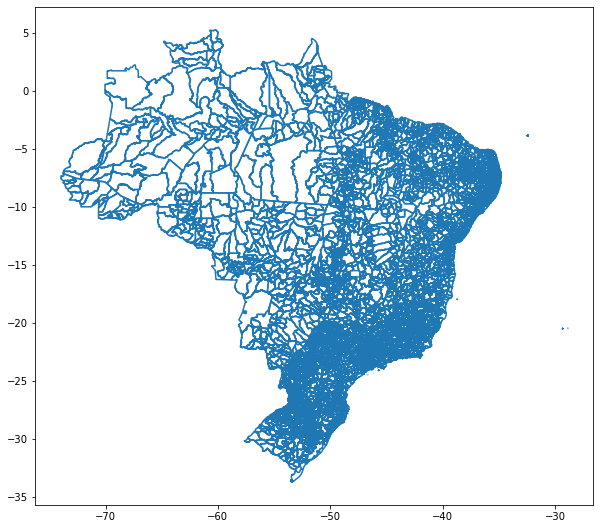

In [44]:
merged_data.boundary.plot(figsize=(10, 10))

In [51]:
invasions = merged_data[merged_data['invasions_dum'] == 1]

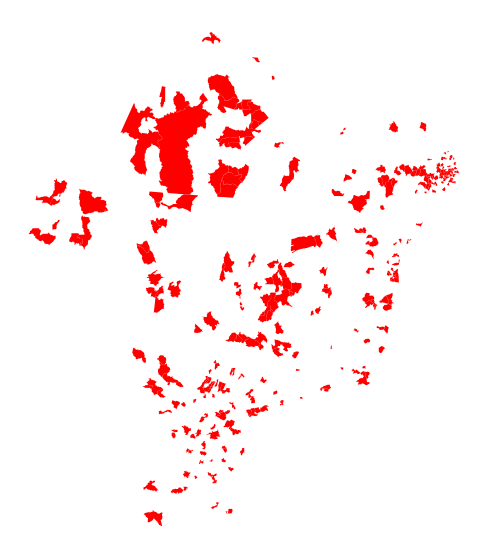

In [58]:
inv_plot = invasions.plot(marker='*', color='red', markersize=5, figsize=(10, 10))
inv_plot.set_axis_off()
plt.show()

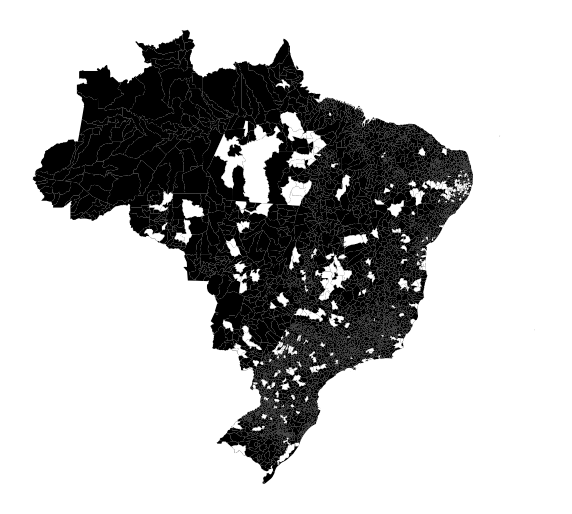

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(ax=ax, color='black')

invasions.plot(ax=ax, color='white')

ax.set_axis_off()
plt.show()

<AxesSubplot:>

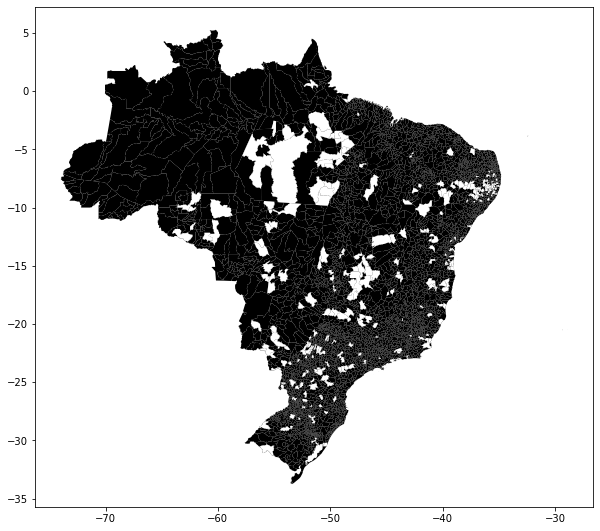

In [61]:
base = merged_data.plot(color='black', figsize=(10, 10))
invasions.plot(ax=base, marker='o', color='white', markersize=5)

<AxesSubplot:>

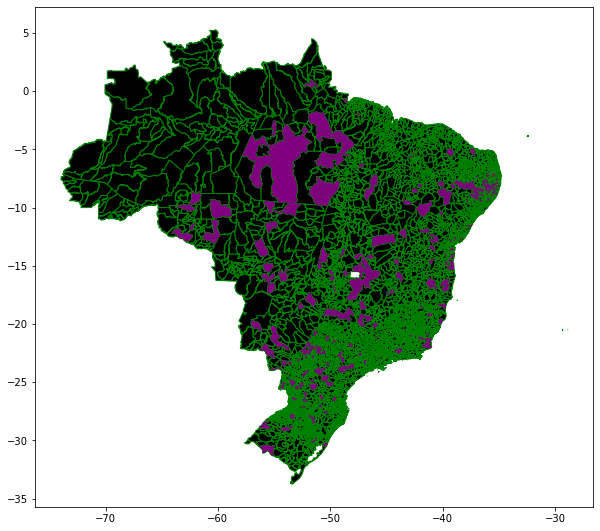

In [63]:
base = merged_data.plot(color='black', edgecolor='green', figsize=(10, 10))
invasions.plot(ax=base, marker='o', color='purple', markersize=5)

### Spatial weight matrix

In [2]:
#pip install pysal

1. conda install --channel conda-forge pysal

(skip second step if you created the geo_env above)

2. conda create -n geo_env

3. conda activate geo_env

4. conda config --env --add channels conda-forge

5. conda config --env --set channel_priority strict

6. conda install python=3 pysal

In [3]:
import pysal as ps

In [40]:
import libpysal

In [5]:
from libpysal.weights import Queen, Rook, KNN

Queen: More inclusive, catches any vertex

Rook: Considers edges

KNN: Equal number of neighbors for each, according to distances

In [7]:
w_knn1 = KNN.from_shapefile('BR/BRMUE250GC_SIR.shp')

C:\Users\user\anaconda\envs\geo_env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  warnings.warn(message)


In [10]:
len(w_knn1.neighbors)

5572

In [17]:
w_knn1.neighbors

{0: [1471, 2958],
 1: [3201, 1597],
 2: [1048, 4229],
 3: [4812, 4545],
 4: [3805, 500],
 5: [2538, 4824],
 6: [1198, 5415],
 7: [659, 4345],
 8: [2723, 3034],
 9: [449, 5231],
 10: [2754, 2980],
 11: [376, 1347],
 12: [4546, 3042],
 13: [3120, 5417],
 14: [5521, 4444],
 15: [3956, 3795],
 16: [4403, 1821],
 17: [4270, 4586],
 18: [2551, 886],
 19: [2460, 597],
 20: [3165, 5105],
 21: [1364, 4199],
 22: [3790, 2575],
 23: [4968, 3002],
 24: [4217, 3745],
 25: [5003, 5331],
 26: [4849, 33],
 27: [3593, 911],
 28: [2047, 1367],
 29: [1596, 3299],
 30: [2221, 3958],
 31: [2398, 1949],
 32: [3033, 2424],
 33: [3747, 4849],
 34: [2613, 2442],
 35: [1285, 4770],
 36: [1220, 5421],
 37: [2610, 506],
 38: [4591, 1753],
 39: [1748, 1936],
 40: [3836, 57],
 41: [3374, 1302],
 42: [1736, 2595],
 43: [5213, 277],
 44: [2506, 4593],
 45: [4137, 3224],
 46: [2804, 1826],
 47: [3152, 3789],
 48: [4640, 3033],
 49: [5078, 2320],
 50: [2131, 832],
 51: [4096, 4786],
 52: [5066, 1228],
 53: [4136, 433],

In [151]:
w_knn3 = KNN.from_shapefile('BR/BRMUE250GC_SIR.shp',3) #default was 2

In [152]:
w_knn3.neighbors

{0: [1471, 2958, 683],
 1: [3201, 1597, 832],
 2: [1048, 4229, 3629],
 3: [4812, 4545, 1070],
 4: [3805, 500, 804],
 5: [2538, 4824, 898],
 6: [1198, 5415, 3582],
 7: [659, 4345, 38],
 8: [2723, 3034, 5569],
 9: [449, 5231, 2195],
 10: [2754, 2980, 5201],
 11: [376, 1347, 5535],
 12: [4546, 3042, 1564],
 13: [3120, 5417, 3555],
 14: [5521, 4444, 4607],
 15: [3956, 3795, 4983],
 16: [4403, 1821, 1415],
 17: [4270, 4586, 3189],
 18: [2551, 886, 4067],
 19: [2460, 597, 1933],
 20: [3165, 5105, 2166],
 21: [1364, 4199, 5462],
 22: [3790, 2575, 3286],
 23: [4968, 3002, 212],
 24: [4217, 3745, 2699],
 25: [5003, 5331, 959],
 26: [4849, 33, 1767],
 27: [3593, 911, 3378],
 28: [2047, 1367, 2923],
 29: [1596, 3299, 4840],
 30: [2221, 3958, 4522],
 31: [2398, 1949, 201],
 32: [3033, 2424, 4033],
 33: [3747, 4849, 939],
 34: [2613, 2442, 1932],
 35: [1285, 4770, 155],
 36: [1220, 5421, 5102],
 37: [2610, 506, 5218],
 38: [4591, 1753, 659],
 39: [1748, 1936, 3891],
 40: [3836, 57, 4275],
 41: [337

In [18]:
w_queen = Queen.from_shapefile('BR/BRMUE250GC_SIR.shp')

In [24]:
len(w_queen.neighbors)

5572

In [25]:
w_queen.neighbors

{0: [4527, 5514, 4204, 2958, 1471],
 1: [832, 3201, 5524, 692, 854, 5017, 1597],
 2: [1048, 3629, 4229, 1686],
 3: [4545, 4678, 4812, 1261, 1070, 1046, 2010, 5534],
 4: [2845, 804, 3805],
 5: [898, 2998, 4824, 2538, 3867],
 6: [2150, 5415, 3582, 1242, 4076, 1198],
 7: [659, 4261, 38, 4345, 1753],
 8: [4392, 5569, 3034, 2723],
 9: [449, 2195, 4980, 5320, 5482, 5231],
 10: [5201, 2754, 2980, 1797, 319],
 11: [1301, 3701, 376, 5337, 5535],
 12: [4546, 1051, 1564, 3042],
 13: [3555, 1575, 5480, 5417, 2988, 1584, 3120, 2898],
 14: [5521, 2271, 1477, 4444, 4607],
 15: [4983, 3956, 4599],
 16: [1415, 330, 5455, 3954, 4403, 4212, 468, 1821, 5565],
 17: [642, 3380, 3189, 4586, 4270],
 18: [1170, 4067, 886, 2551, 4269],
 19: [2460, 2436, 597, 5081, 444, 1933],
 20: [5105, 3165, 2166, 4456, 3947, 5389],
 21: [4199, 2668, 2508, 4749, 1364, 2934, 5462, 377, 1274],
 22: [3790, 3325, 3286, 2575],
 23: [212, 4968, 3002, 2348, 2509],
 24: [89, 3745, 4217, 2699],
 25: [2114, 5331, 164, 2036, 5003, 959],

In [23]:
w_rook = Rook.from_shapefile('BR/BRMUE250GC_SIR.shp')

In [26]:
len(w_rook.neighbors)

5572

In [27]:
w_rook.neighbors

{0: [4527, 5514, 4204, 2958, 1471],
 1: [832, 3201, 5524, 692, 854, 1597],
 2: [1048, 3629, 4229, 1686],
 3: [4545, 4678, 4812, 1261, 1070, 1046, 2010, 5534],
 4: [804, 2845],
 5: [898, 2998, 4824, 2538, 3867],
 6: [2150, 5415, 3582, 1242, 4076, 1198],
 7: [4345, 659, 4261, 38],
 8: [4392, 5569, 3034, 2723],
 9: [449, 2195, 4980, 5320, 5482, 5231],
 10: [5201, 2754, 2980, 1797, 319],
 11: [3701, 1301, 376, 5337, 5535],
 12: [4546, 1051, 1564, 3042],
 13: [3555, 1575, 5480, 5417, 2988, 1584, 3120, 2898],
 14: [5521, 2271, 1477, 4444, 4607],
 15: [4983, 3956, 4599],
 16: [1415, 330, 5455, 3954, 4403, 4212, 468, 1821, 5565],
 17: [642, 3380, 3189, 4586, 4270],
 18: [1170, 4067, 886, 2551, 4269],
 19: [2436, 597, 5081, 444, 2460, 1933],
 20: [5105, 2166, 4456, 5389, 3947, 3165],
 21: [4199, 2668, 2508, 4749, 1364, 2934, 5462, 377, 1274],
 22: [3790, 3325, 3286, 2575],
 23: [212, 4968, 3002, 2348, 2509],
 24: [89, 3745, 4217, 2699],
 25: [2114, 5331, 164, 2036, 5003, 959],
 26: [4849, 3236,

In [35]:
w_rook.neighbors[4]

[804, 2845]

In [36]:
w_queen.neighbors[4]

[2845, 804, 3805]

In [41]:
#We can call weight object directly from the dataframe
wq = libpysal.weights.Queen.from_dataframe(merged_data)
wq

C:\Users\user\anaconda\envs\geo_env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3318, 4005.
  warnings.warn(message)


In [69]:
#We need to standardize our weights with respect to rows
wq.transform = 'r'

### Produce spatial lags

In [48]:
merged_data['invasions_count_splag'] = libpysal.weights.lag_spatial(wq, merged_data['invasions_count'])

In [49]:
merged_data['invasions_count_splag'],merged_data['invasions_count']

0       0.000000
1       0.000000
2       0.250000
3       0.000000
4       0.000000
          ...   
5564    0.142857
5565    0.000000
5566    0.000000
5567    0.000000
5568    0.600000
Name: invasions_count_splag, Length: 5569, dtype: float64

In [54]:
merged_data['invasions_count'].corr(merged_data['invasions_count_splag'])

0.24202801996457463

In [55]:
merged_data['BF_coverage1000_splag'] = libpysal.weights.lag_spatial(wq, merged_data['BF_coverage1000'])
merged_data['BF_coverage1000'].corr(merged_data['BF_coverage1000_splag'])

0.8144535864694518

!!! Spatial autocorrelation alert !!!

### Run the Spatial regression

http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html

In [60]:
merged_data = merged_data.dropna(axis=0)

In [ ]:
#pip install spreg

In [82]:
import spreg

In [ ]:
#spreg only works with numpy arrays

In [86]:
y = merged_data['BF_coverage1000'].values

array([ 42.53759 ,  82.94931 ,  92.666756, ...,  28.597105,  23.22335 ,
       158.25488 ], dtype=float32)

In [136]:
x_OLS = merged_data[['invasions_count_cum', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality']].values
x_OLS

array([[0.00000000e+00, 5.96061850e+00, 4.07823372e+00, 5.13432836e-02,
        2.38095245e+01],
       [0.00000000e+00, 5.76755524e+00, 4.37417364e+00, 4.30399380e-02,
        2.50000000e+01],
       [1.00000000e+00, 4.75354719e+00, 3.45397949e+00, 1.47119768e-02,
        2.23048325e+01],
       ...,
       [0.00000000e+00, 6.45536375e+00, 5.45690107e+00, 2.69398883e-01,
        1.55666256e+01],
       [0.00000000e+00, 6.08203602e+00, 4.16811943e+00, 3.81124193e-01,
        3.09278355e+01],
       [7.00000000e+00, 5.34594011e+00, 4.43830729e+00, 3.05718867e-02,
        1.36986303e+01]])

In [99]:
#We can redefine a weighting matrix, reading neighbors and weights
#from libpysal.weights import W
#w_matrix = W(wq.neighbors, wq.weights)

In [100]:
#We dropped some observations, then we need to recalculate the weights, to keep the total size consistent 
wq = libpysal.weights.Queen.from_dataframe(merged_data)
wq.transform = 'r'

C:\Users\user\anaconda\envs\geo_env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


##### OLS with spreg

In [137]:
model_OLS = spreg.OLS(
    y[:, None],
    x_OLS,
    w=wq,
    spat_diag=True,
    #name_x=['invasions_count_cum', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality'], 
    #name_y='Bolsa Familia'
)

print(model_OLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        4885
Mean dependent var  :     70.5033                Number of Variables   :           6
S.D. dependent var  :     38.5179                Degrees of Freedom    :        4879
R-squared           :      0.5642
Adjusted R-squared  :      0.5637
Sum squared residual: 3157942.207                F-statistic           :   1263.2124
Sigma-square        :     647.252                Prob(F-statistic)     :           0
S.E. of regression  :      25.441                Log likelihood        :  -22738.170
Sigma-square ML     :     646.457                Akaike info criterion :   45488.339
S.E of regression ML:     25.4255                Schwarz criterion     :   45527.303

-----------------------------------------------------------------------------

DIAGNOSTICS FOR SPATIAL DEPENDENCE: The main summary from the diagnostics for spatial dependence is that there is clear evidence to reject the null of spatial randomness in the residuals, hence an explicitly spatial approach is warranted.

##### Including Spatial lag of X

In [139]:
x_splag_X = merged_data[['invasions_count_cum', 'invasions_count_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality']].values

In [140]:
model_splag_of_X = spreg.OLS(
    y[:, None],
    x_splag_X,
    w=wq,
    spat_diag=True,
    #name_x=['invasions_count_cum', 'invasions_count_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality'], 
    #name_y='Bolsa Familia'
)

print(model_splag_of_X.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        4885
Mean dependent var  :     70.5033                Number of Variables   :           7
S.D. dependent var  :     38.5179                Degrees of Freedom    :        4878
R-squared           :      0.5642
Adjusted R-squared  :      0.5637
Sum squared residual: 3157877.252                F-statistic           :   1052.4996
Sigma-square        :     647.371                Prob(F-statistic)     :           0
S.E. of regression  :      25.443                Log likelihood        :  -22738.119
Sigma-square ML     :     646.444                Akaike info criterion :   45490.239
S.E of regression ML:     25.4253                Schwarz criterion     :   45535.696

-----------------------------------------------------------------------------

##### Including Spatial lag of Y

In [141]:
x_splag_Y = merged_data[['invasions_count_cum', 'BF_coverage1000_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality']].values

In [142]:
model_splag_of_Y = spreg.OLS(
    y[:, None],
    x_splag_Y,
    w=wq,
    spat_diag=True,
    #name_x=['invasions_count_cum', 'BF_coverage1000_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality'], 
    #name_y='Bolsa Familia'
)

print(model_splag_of_Y.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        4885
Mean dependent var  :     70.5033                Number of Variables   :           7
S.D. dependent var  :     38.5179                Degrees of Freedom    :        4878
R-squared           :      0.6924
Adjusted R-squared  :      0.6921
Sum squared residual: 2228645.756                F-statistic           :   1830.3177
Sigma-square        :     456.877                Prob(F-statistic)     :           0
S.E. of regression  :      21.375                Log likelihood        :  -21886.894
Sigma-square ML     :     456.222                Akaike info criterion :   43787.787
S.E of regression ML:     21.3594                Schwarz criterion     :   43833.245

-----------------------------------------------------------------------------

##### Including both spatial lags

In [144]:
x_splags = merged_data[['invasions_count_cum', 'invasions_count_splag', 'BF_coverage1000_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality']].values

In [145]:
model_splags_both= spreg.OLS(
    y[:, None],
    x_splags,
    w=wq,
    spat_diag=True,
    #name_x=['invasions_count_cum', 'invasions_count_splag', 'BF_coverage1000_splag', 'log_income', 'ln_agriculturalproductivity', 'PT_voteshare','infantmortality'], 
    #name_y='Bolsa Familia'
)

print(model_splags_both.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        4885
Mean dependent var  :     70.5033                Number of Variables   :           8
S.D. dependent var  :     38.5179                Degrees of Freedom    :        4877
R-squared           :      0.6925
Adjusted R-squared  :      0.6920
Sum squared residual: 2228458.776                F-statistic           :   1568.7122
Sigma-square        :     456.932                Prob(F-statistic)     :           0
S.E. of regression  :      21.376                Log likelihood        :  -21886.689
Sigma-square ML     :     456.184                Akaike info criterion :   43789.377
S.E of regression ML:     21.3585                Schwarz criterion     :   43841.329

-----------------------------------------------------------------------------

!!!! Let's compare results !!!!

In [146]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(y, model_OLS.predy.flatten()),
                     'splag_of_X': mse(y, model_splag_of_X.predy.flatten()),
                     'splag_of_Y': mse(y, model_splag_of_Y.predy.flatten()),
                     'both_splags': mse(y, model_splags_both.predy.flatten())
                    })
mses.sort_values()

both_splags    456.183987
splag_of_Y     456.222263
splag_of_X     646.443654
OLS            646.456951
dtype: float64

### IV2sls with spatial lags

In [58]:
#If you are working in geo_env, your environment probably does not have "linearmodels" package. Then pip it!
#pip install linearmodels

In [67]:
type(merged_data)

geopandas.geodataframe.GeoDataFrame

In [68]:
#Conver geopandas dataframe into a pandas dataframe object
merged_data_pd = pd.DataFrame(merged_data)

In [66]:
type(merged_data_pd)

pandas.core.frame.DataFrame

In [64]:
import linearmodels
from linearmodels.iv import IV2SLS
sp_formula = 'BF_coverage1000 ~ 1 + log_income + ln_agriculturalproductivity + PT_voteshare + infantmortality + BF_coverage1000_splag + invasions_count_splag + [log_invasions_count_cum ~ log_intended_lands1995]'
iv2sls = IV2SLS.from_formula(sp_formula, merged_data_pd).fit()
iv2sls

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:        BF_coverage1000   R-squared:                      0.6905
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6900
No. Observations:                4885   F-statistic:                  1.19e+04
Date:                Sat, Aug 06 2022   P-value (F-stat)                0.0000
Time:                        14:09:18   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                      
===============================================================================================
                             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------
Intercept                       146.17     8.4760     17.246     0.0000      129.56      162.79
BF_coverage1000_splag           0.6953     0.0181     38.340     0.0000      0.6598      0.7309
PT_voteshare                   -9.0446     3.4673    -2.6085     0.0091     -15.840     -2.2488
infantmortality                -0.0110     0.0238    -0.4620     0.6441     -0.0576      0.0356
invasions_count_splag           2.9139     1.8298     1.5924     0.1113     -0.6726      6.5003
ln_agriculturalproductivity    -1.5215     0.3094    -4.9175     0.0000     -2.1279     -0.9151
log_income                     -20.442     1.2738    -16.048     0.0000     -22.939     -17.946
log_invasions_count_cum        -4.5219     1.8172    -2.4883     0.0128     -8.0837     -0.9602
===============================================================================================

Endogenous: log_invasions_count_cum
Instruments: log_intended_lands1995
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x11779d9ffa0